# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.msklm import *

In [9]:
config = mlm_config(vocab)

In [10]:
# config['n_layers'] = 2
# # config['bptt'] = 512
# config['bs'] = 8
# config['mem_len'] = 32

In [11]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312}

In [12]:
base_path = Path('../../data/midi/v18/sf4/')

In [13]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## Either or Data

In [14]:
dl_tfms = [partial(mask_or_lm_tfm, p_lm=0.5)]
# dl_tfms = [random_msklm_tfm]
msklm_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                              y_offset=1, dl_tfms=dl_tfms, **config)


In [15]:
xb,yb = msklm_data.one_batch();

In [16]:
xb

[tensor([[149,   0,   1,  ...,  56, 145,  52],
         [149,   0,   1,  ...,  56,   4,   4],
         [149,   0,   1,  ...,   4, 145,  52],
         ...,
         [ 86,   0,   1,  ...,   4,   4,  52],
         [149,   0,   1,  ...,  56,   4,  52],
         [149,   0,   1,  ...,   4, 145,  52]]),
 None,
 tensor([[-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         ...,
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16]]),
 None]

## S2S Dataloading

In [17]:
np.pad(np.ones((4,1)), [(1,0),(0,0)], 'constant')

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [18]:
m2c_dl_tfms = [s2s_tfm]
m2c_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=m2c_dl_tfms,
                               shuffle_dl=True, **config)

c2m_dl_tfms = [partial(s2s_tfm, mlm_type=MLMType.C2M)]
c2m_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=c2m_dl_tfms,
                               shuffle_dl=True, **config)

In [19]:
m2c_data.train_dl.dl.dataset.on_epoch_begin()
m2c_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = m2c_data.one_batch(); [x.shape for x in xb], yb[0].shape

([torch.Size([16, 256]),
  torch.Size([16, 256]),
  torch.Size([16, 256]),
  torch.Size([16, 256])],
 torch.Size([16, 256]))

## Datasets

In [20]:
datasets = [msklm_data, m2c_data, c2m_data]
combined_data = CombinedData(datasets)

# datasets = [nw_data]

## MSKLM

## Load

In [21]:
loss_func = MLMLoss()
learn = mlm_model_learner(combined_data, config.copy(), 
# learn = mlm_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

In [22]:
learn.metrics = [acc_ignore_pad, mask_acc, lm_acc, c2m_acc, m2c_acc]

In [23]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(MLMTrainer(learn))

In [24]:
[type(c) for c in learn.callbacks]

[src.msklm.MLMTrainer]

In [25]:
learn = learn.to_fp16()

### Training

In [26]:
learn.validate()

[5.8183403,
 tensor(0.0165),
 tensor(0.0957),
 tensor(0.),
 tensor(0.0011),
 tensor(0.0021)]

In [27]:
# try_pos again - max_norm 0.5
# learn.fit_one_cycle(2, 1e-3)

In [28]:
# learn.save('save_s2s_1')

## Load existing

In [29]:
saved_models = get_files(base_path/'piano_duet/models/mlm/hook_c', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/3_ep60.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/3_ep60_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/4_90_reenc_best.pth')]

In [30]:
load_path = saved_models[-1]
state = torch.load(load_path, map_location='cpu')
m = get_model(learn.model)
load_path

PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/4_90_reenc_best.pth')

In [31]:
m.load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/4_90_reenc_best.pth')

## Predict Mask

In [32]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [33]:
idx = -1
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [34]:
file2stream(orig).show('midi')

In [35]:
song_np = np.load(file)
xb = torch.tensor(song_np)[...,0]
if torch.cuda.is_available(): xb = xb.cuda()

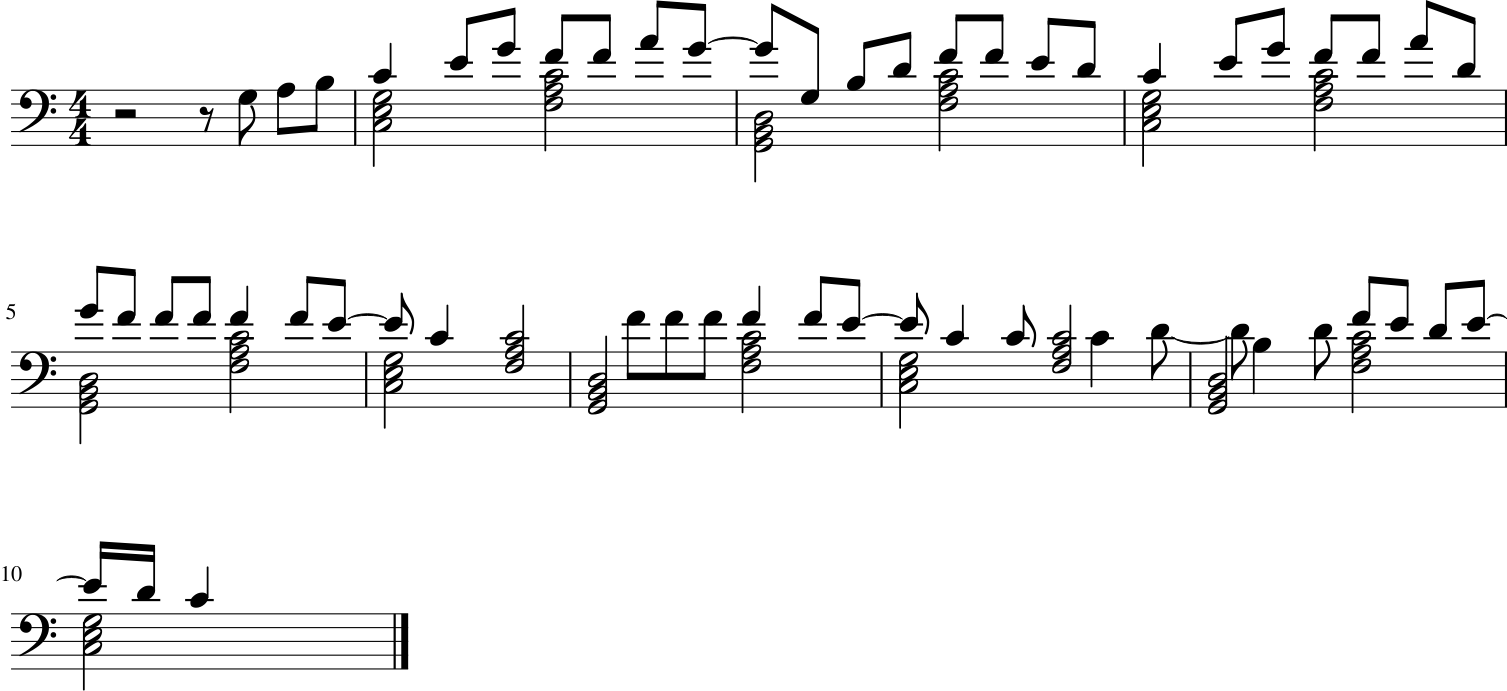

In [36]:
npenc2stream(to_double_stream(xb.cpu().numpy())).show()

In [37]:
song_np

array([[   0,    0],
       [   1,    0],
       [   8,    0],
       [ 147,    0],
       ...,
       [   8, -145],
       [ 138, -145],
       [  69, -146],
       [ 141, -146]])

In [38]:
def predict_mask(self, xb:Tensor,
                temperatures:float=(1.0,1.0),
                top_k=20, top_p=0.8):
    xb = xb.clone().squeeze()[None]
    self.model.reset()
    mask_idxs = (xb == vocab.mask_idx).nonzero()
    for midx in progress_bar(mask_idxs, leave=True):
        
        pos = torch.tensor(position_enc(xb[0].cpu().numpy()), device=xb.device)[None]
#         print(pos)
        
        # Next Word
        res = self.pred_batch(batch=((xb, None, pos, None),xb))
        res = F.softmax(res[tuple(midx)], dim=-1) # task1, task2 - (bs x ts x vocab)
    
        # Don't allow any special tokens (as we are only removing notes and durations)
        res[vocab.bos_idx] = 0.
        res[vocab.sep_idx] = 0.
        res[vocab.stoi[EOS]] = 0

        # Use first temperatures value if last prediction was duration
        temperature = temperatures[0]
        if temperature != 1.: res.pow_(1 / temperature)

        res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
        idx = torch.multinomial(res, 1).item()
        #         idx = res.argmax()

        xb[tuple(midx)] = idx
        
    return xb.cpu().numpy()

#### Regenerate durations

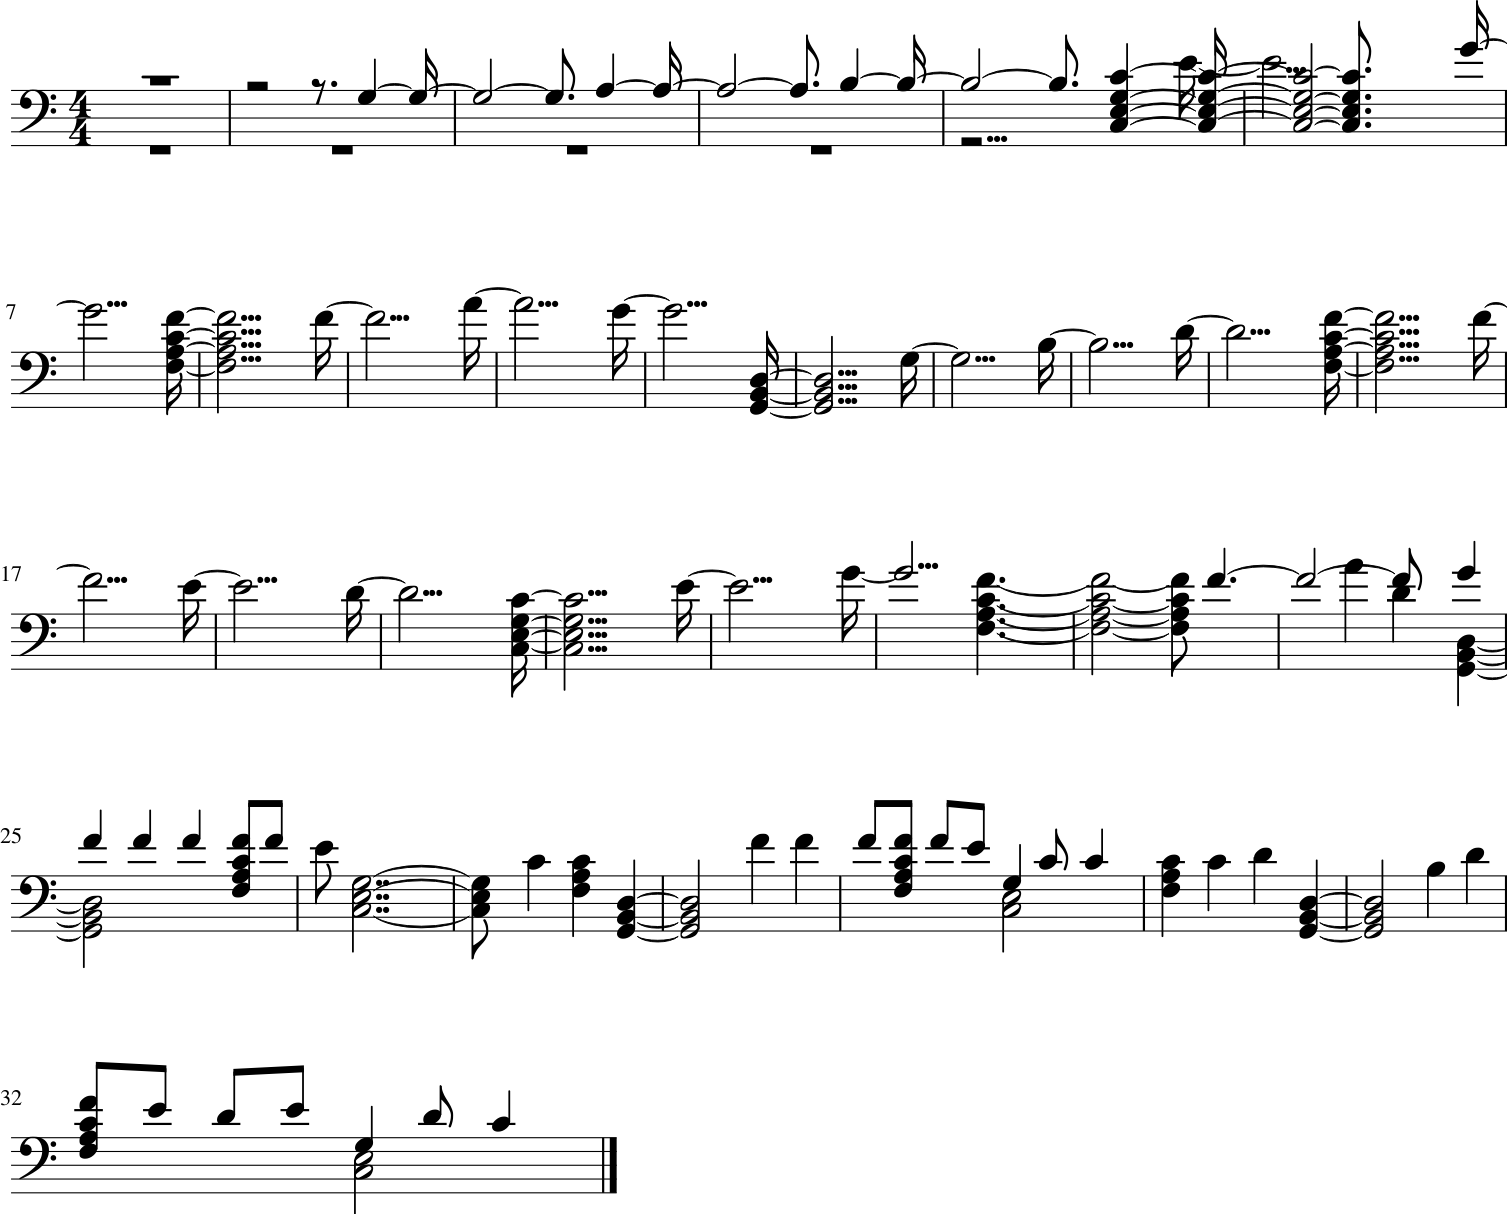

In [39]:
# duration mask
xb_dur = mask_input(xb, mask_range=vocab.dur_range)

pred = predict_mask(learn, xb_dur, temperatures=(0.8,0.8))
pred = to_double_stream(pred)

stream_dur = npenc2stream(pred)
stream_dur.show()

In [40]:
stream_dur.show('midi')

#### Regenerate Notes

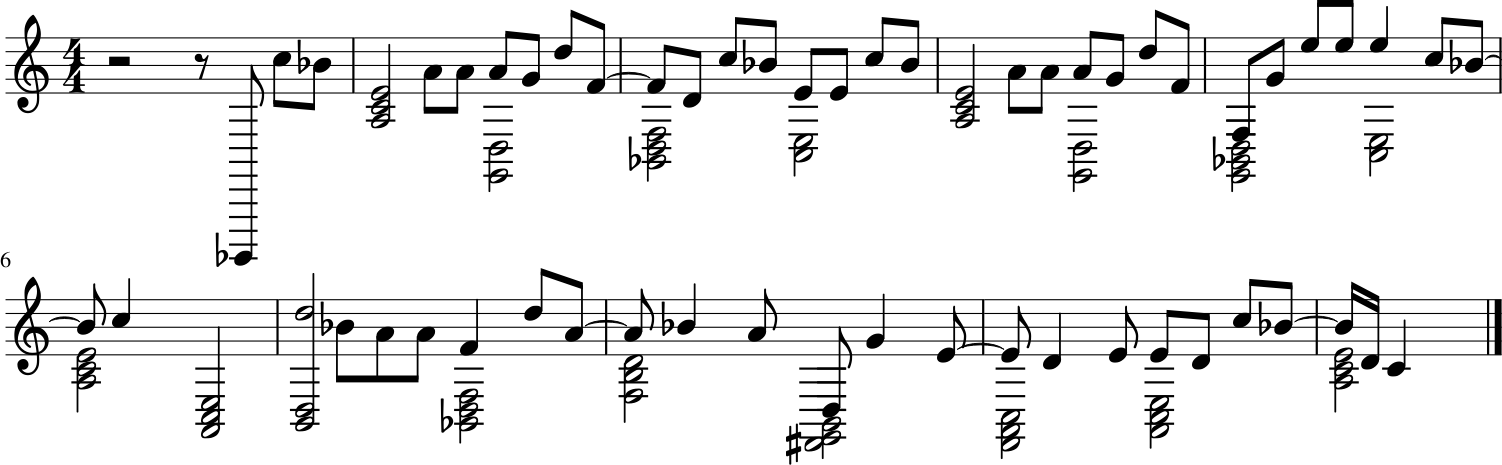

In [41]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
xb_note = mask_input(xb, mask_range=vocab.note_range)
pred_note = learn.predict_mask(xb_note)
pred_note = to_double_stream(pred_note)

stream_note = npenc2stream(pred_note)
stream_note.show()

In [42]:
song_np = np.load(file)
xb = torch.tensor(to_single_stream(song_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [43]:
def mask_predict_from_midi(learn, midi=None,
                           temperatures=(1.0,1.0), top_k=20, top_p=0.8, 
                           predict_notes=True,
                           **kwargs):
    seed_np = midi2npenc(midi) # music21 can handle bytes directly
    xb = torch.tensor(to_single_stream(seed_np))[None]
    mask_range = vocab.note_range if predict_notes else vocab.dur_range
    xb = mask_input(xb, mask_range=vocab.note_range)
    if torch.cuda.is_available(): xb = xb.cuda()
    pred = learn.predict_mask(xb, temperatures=temperatures, top_k=top_k, top_p=top_p)
    pred = to_double_stream(pred)
    return pred

In [44]:
np.array([1,2]).copy()

array([1, 2])

In [45]:
out = mask_predict_from_midi(learn, orig)

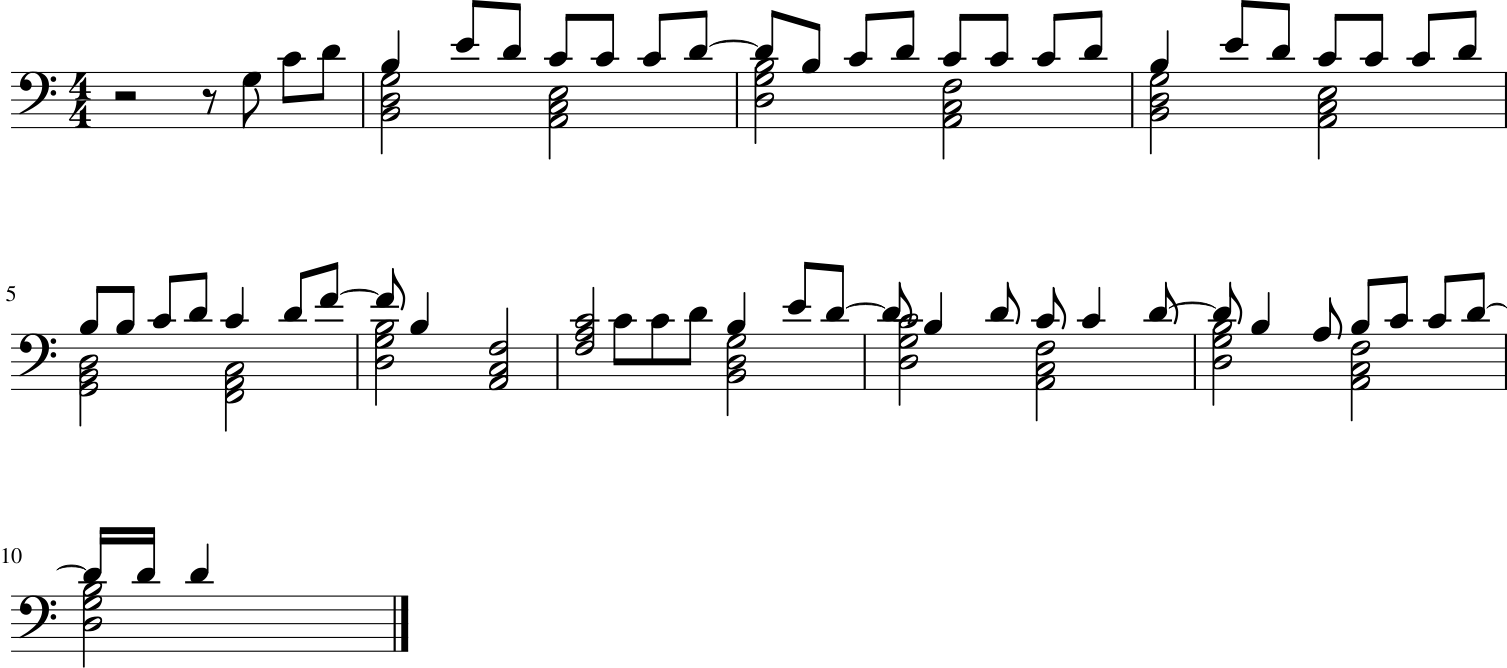

In [46]:
npenc2stream(out).show()

## Prediction next word

In [47]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [48]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [49]:
seed_len = 40
song_np = np.load(file)[:seed_len]
xb = torch.tensor(song_np)
if torch.cuda.is_available(): xb = xb.cuda()

In [50]:
song_np.shape

(40, 2)

In [51]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [52]:
self = learn
self.model.reset()
if xb.shape == 3: xb = xb[0]
x = xb[:,0]

In [53]:

def predict_nw(self, xb:Tensor, n_words:int=128,
                 temperatures:float=(1.0,1.0), min_bars=4,
                 top_k=40, top_p=0.9):
    "Return the `n_words` that come after `text`."
    self.model.reset()
        
    seed = xb.cpu().numpy().squeeze()
    new_idx = []
    pos = torch.tensor(position_enc(xb.cpu().numpy()), device=xb.device)
    last_pos = pos[-1]
    
    sep_count = 0
    bar_len = SAMPLE_FREQ * 4 # assuming 4/4 time
    vocab = self.data.vocab

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):
            res = self.pred_batch(batch=((None, xb[None], None, pos[None]),xb[None]))[-1][-1]

            # bar = 16 beats
            if (sep_count // 16) <= min_bars: res[vocab.bos_idx] = 0.

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(new_idx)==0 or self.data.vocab.is_duration(new_idx[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()

            if new_idx and new_idx[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                sep_count += duration
#                 print('Updating positional encoding:', last_pos, last_pos - duration)
                last_pos = last_pos - duration # position is negative
#                 print('Bars', duration, sep_count // 16)

            if idx==vocab.bos_idx: 
                print('Predicted BOS token. Returning prediction...')
                break

            new_idx.append(idx)
            xb = xb.new_tensor([idx])
            pos = pos.new_tensor([last_pos])
    return np.array(new_idx), seed


In [54]:
out_s, seed_s = predict_nw(learn, x, n_words=40)

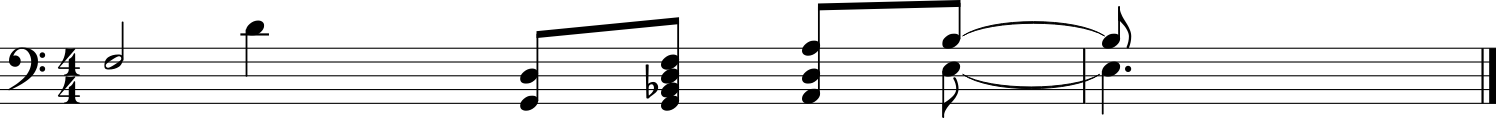

In [55]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [56]:
stream.show('midi')

In [57]:

def nw_predict_from_midi(learn, midi=None, n_words=600, 
                      temperatures=(1.0,1.0), top_k=24, top_p=0.7, **kwargs):
    seed_np = to_single_stream(midi2npenc(midi)) # music21 can handle bytes directly
    xb = torch.tensor(seed_np)
    if torch.cuda.is_available(): xb = xb.cuda()
#     pred, seed = learn.predict_nw(xb, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)
    pred, seed = predict_nw(learn, xb, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)
    seed = to_double_stream(seed)
    pred = to_double_stream(pred)
    full = np.concatenate((seed,pred), axis=0)
    return full

In [58]:
out = nw_predict_from_midi(learn, orig)

## Predict Seq2Seq

In [59]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,7,9,11,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ht_mode,title,genres,source,section,midi,artist,parts,ht_bpm,midi_title,ht_time_signature,ht_key,ht_offset,md5,song_url,numpy,mxl
193164,1.0,la-bamba,"Pop,Rock",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,chorus,144.0,La Bamba,4.0,C,0.0,aeee134e4034e5f98bb630c56d2f7f8c,https://www.hooktheory.com/theorytab/view/ritc...,sf4/s2s_encode/hooktheory/pianoroll/r/ritchie-...,NaN


In [60]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/s2s_encode/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [61]:
melody_np, chord_np = np.load(file, allow_pickle=True)

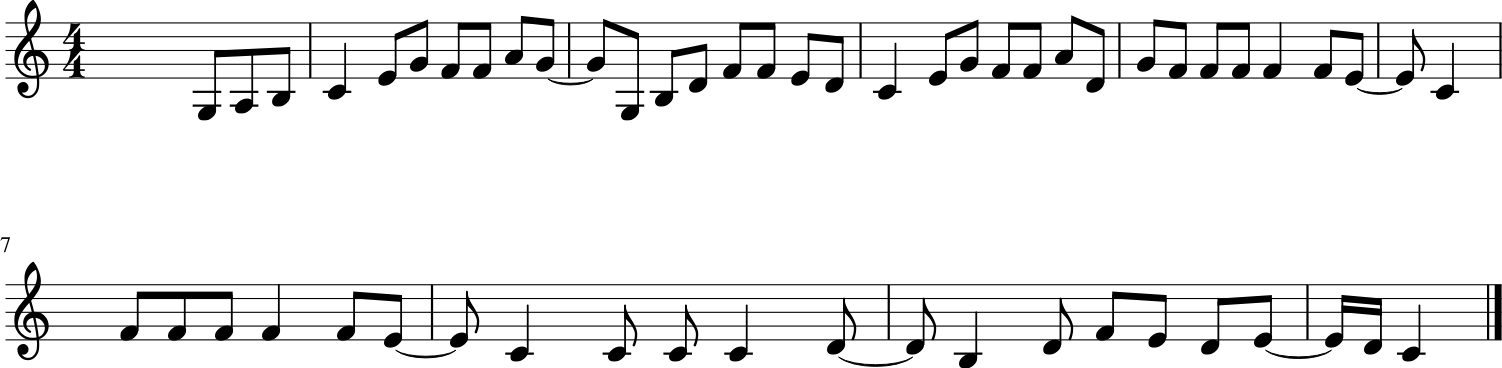

In [62]:
npenc2stream(to_double_stream(melody_np[...,0])).show()

In [63]:
melody_np

array([[   6,    0],
       [   1,    0],
       [   8,    0],
       [ 147,    0],
       ...,
       [ 138, -145],
       [  69, -146],
       [ 141, -146],
       [   2, -146]])

In [64]:
learn.model.reset()

In [65]:

def predict_s2s(self, xb_msk:Tensor, xb_lm:Tensor, n_words:int=128,
                temperatures:float=(1.0,1.0),
                top_k=40, top_p=0.9):
    self.model.reset()
    
    
    x_lm = xb_lm.tolist()
    lm_pos = position_enc(xb_lm.cpu().numpy()).tolist()
    last_pos = lm_pos[-1]
    
    msk_pos = torch.tensor(position_enc(xb_msk.cpu().numpy()), device=xb_msk.device)
    x_enc = self.model.encoder(xb_msk.view(1, -1), msk_pos.view(1, -1))

    for i in progress_bar(range(n_words), leave=True):
        
        # Next Word
        x, pos = torch.tensor(x_lm, device=xb_lm.device)[None], torch.tensor(lm_pos, device=xb_lm.device)[None]
        dec = self.model.decoder(x, pos, x_enc) # all tasks include mask decoding
        res = F.softmax(self.model.head(dec), dim=-1)[-1, -1]

        # Use first temperatures value if last prediction was duration
        temperature = temperatures[0] if (len(x_lm)==0 or self.data.vocab.is_duration(x_lm[-1])) else temperatures[1]
        if temperature != 1.: res.pow_(1 / temperature)

        res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
        idx = torch.multinomial(res, 1).item()
        #         idx = res.argmax()

        if idx == vocab.bos_idx | idx == vocab.stoi[EOS]: 
            print('Predicting BOS/EOS')
            break
            
        if x_lm and x_lm[-1]==vocab.sep_idx: 
            duration = idx - vocab.dur_range[0]
#             sep_count += duration
#             print('Updating positional encoding:', last_pos, last_pos - duration)
            last_pos = last_pos - duration # position is negative
            
        lm_pos.append(last_pos)
        x_lm.append(idx)

    return np.array(x_lm)

In [66]:
seed_len = 30
xb_msk = torch.tensor(chord_np)[:, 0].cuda()
xb_lm = torch.tensor(melody_np[:seed_len, 0]).cuda()

In [67]:
xb_msk.shape, xb_lm.shape

(torch.Size([139]), torch.Size([30]))

In [68]:
out = predict_s2s(learn, xb_msk, xb_lm)

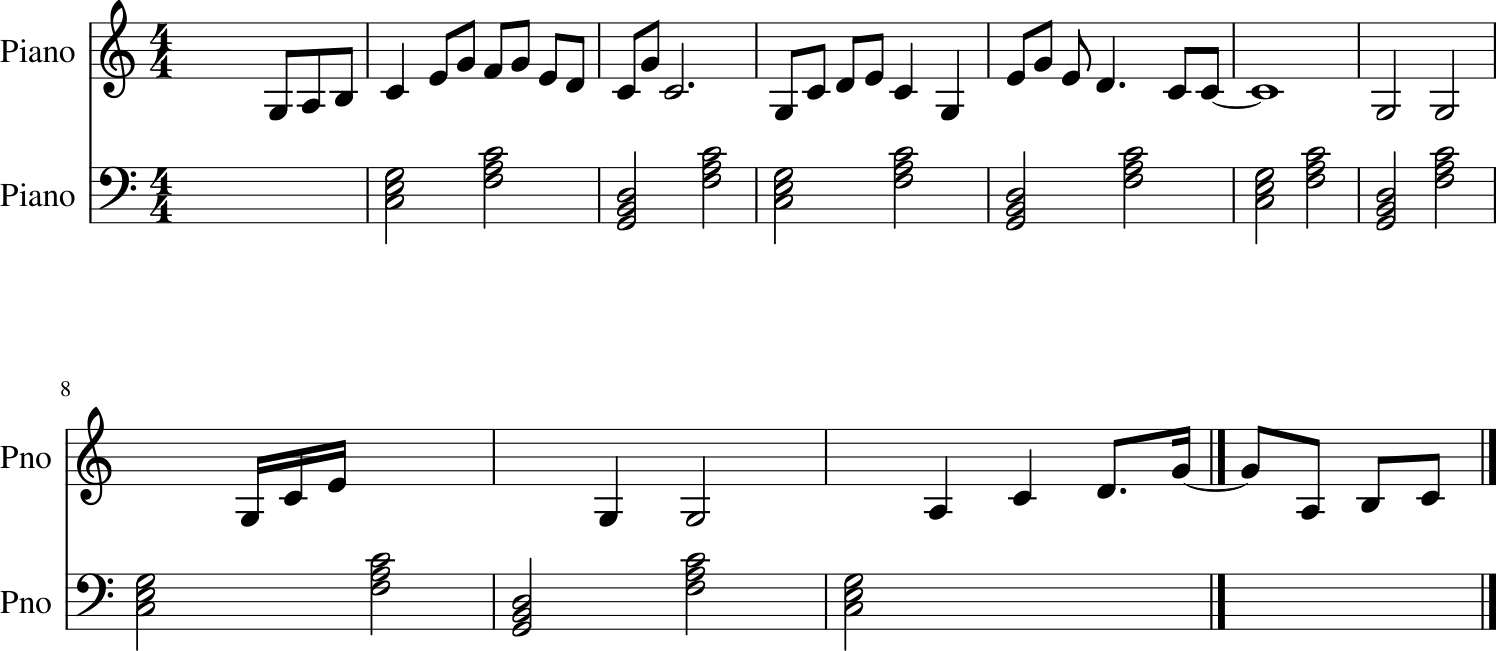

In [69]:
seed_npenc = to_double_stream(xb_msk.cpu().numpy())
yb_npenc = to_double_stream(out)
chordarr_comb = combined_npenc2chordarr(yb_npenc, seed_npenc)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [70]:
comb_stream.show('midi')

In [71]:

def s2s_predict_from_midi(learn, midi=None, n_words=200, 
                      temperatures=(1.0,1.0), top_k=24, top_p=0.7, pred_melody=True, **kwargs):

    stream = file2stream(midi) # 1.
    chordarr = stream2chordarr(stream) # 2.
    _,num_parts,_ = chordarr.shape
    p1, p2 = [part_enc(chordarr, i) for i in range(num_parts)]
    
    part_order = (MSEQ, CSEQ) if avg_pitch(p1) > avg_pitch(p2) else (CSEQ, MSEQ)
    
    mpart = torch.tensor(partenc2seq2seq(p1, part_type=part_order[0]))[:30]
    cpart = torch.tensor(partenc2seq2seq(p2, part_type=part_order[1]))
    
    xb, yb = (cpart, mpart) if pred_melody else (mpart, cpart)
    if torch.cuda.is_available(): xb, yb = xb.cuda(), yb.cuda()
    
#     pred = learn.predict_s2s(xb, yb, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)
    pred = predict_s2s(learn, xb, yb, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)
    # pred = yb

    seed_npenc = to_double_stream(xb.cpu().numpy()) # chord
    yb_npenc = to_double_stream(pred) # melody
    npenc_order = [yb_npenc, seed_npenc] if pred_melody else [seed_npenc, yb_npenc]
    chordarr_comb = combined_npenc2chordarr(*npenc_order)

    return chordarr_comb

In [72]:
out = s2s_predict_from_midi(learn, orig)

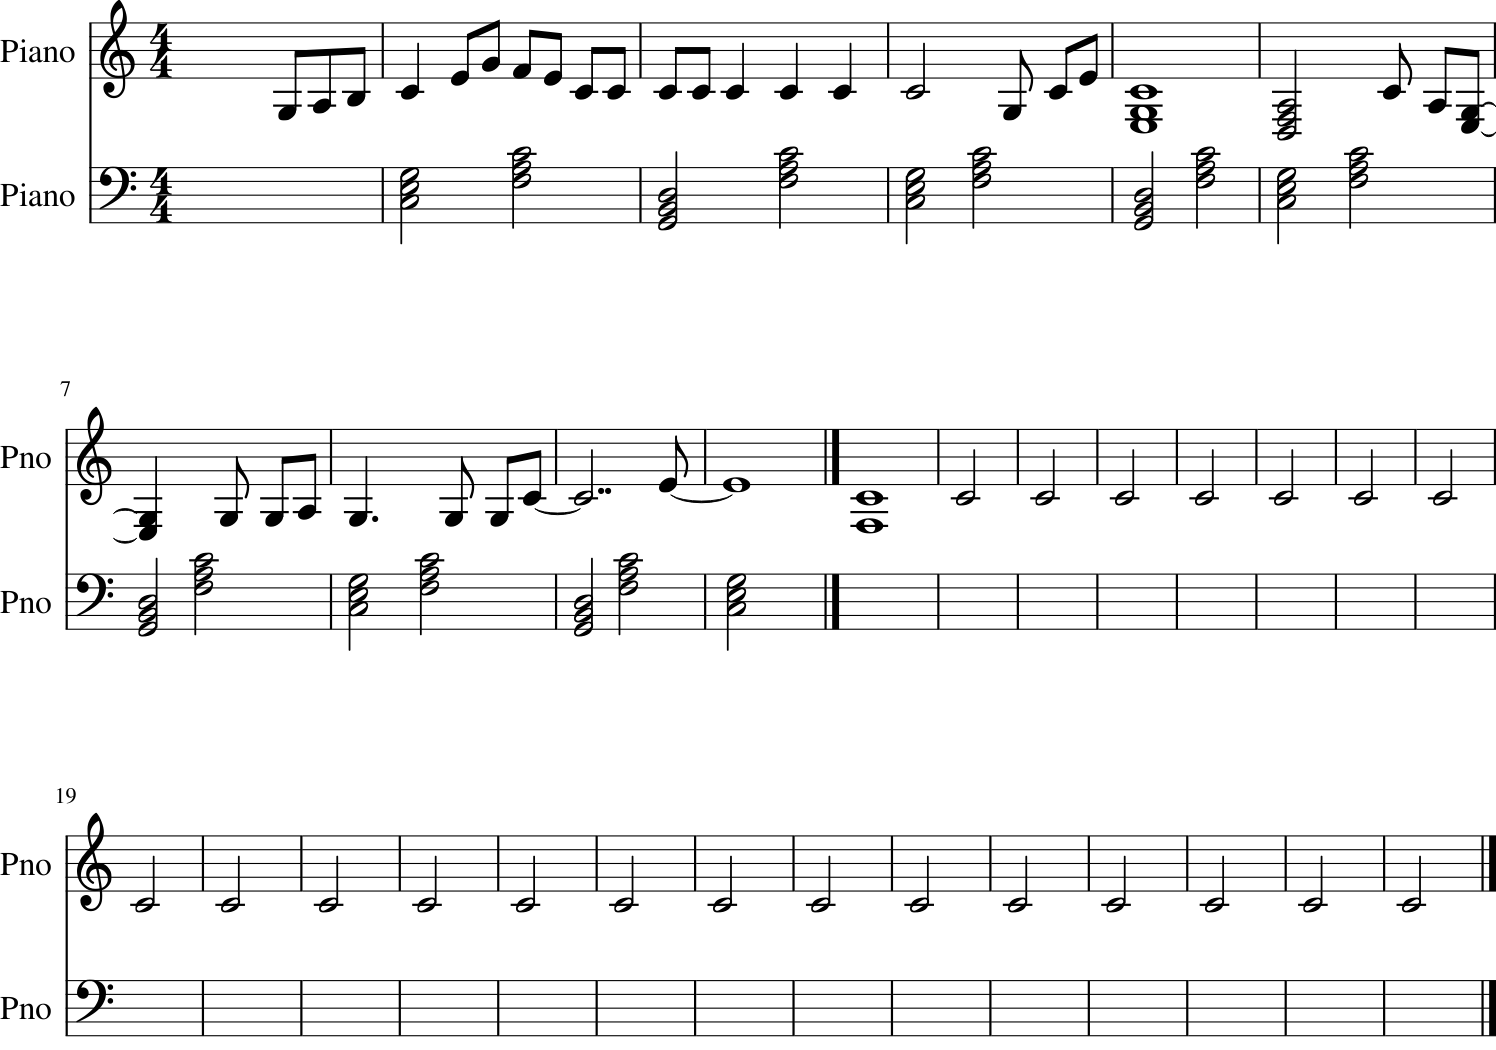

In [73]:
comb_stream = chordarr2stream(out, bpm=108)
comb_stream.show()